### Part 1 Diabetes

In [1]:
from scipy.io import arff
import pandas as pd
from GAN import GAN
from GAN_Twist import GAN_RF
from Dataset import Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Diabetes

In [2]:
data = Dataset('Assignment 4 files/diabetes.arff')
data.norm(method='MinMaxScaler')
X_embedded = data.learn_embeddings()

In [3]:
#Define the GAN and training parameters
noise_dim = 5
dim = 10
batch_size = 32

log_step = 100
epochs = 5001
learning_rate = 5e-4
models_dir = 'model_diabetes'


gan_args = [batch_size, learning_rate, noise_dim, data.norm_df.shape[1], dim]
train_args = ['', epochs, log_step]

model = GAN

#Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
synthesizer = model(gan_args)
history = synthesizer.train(data.norm_df, train_args)

0 [D loss: 0.684817, acc.: 75.00%] [G loss: 0.695573]
generated_data
100 [D loss: 0.676196, acc.: 64.06%] [G loss: 0.710268]
generated_data
200 [D loss: 0.684594, acc.: 54.69%] [G loss: 0.713495]
generated_data
300 [D loss: 0.695464, acc.: 48.44%] [G loss: 0.670813]
generated_data
400 [D loss: 0.695159, acc.: 50.00%] [G loss: 0.708023]
generated_data
500 [D loss: 0.694754, acc.: 43.75%] [G loss: 0.697885]
generated_data
600 [D loss: 0.697110, acc.: 46.88%] [G loss: 0.706686]
generated_data
700 [D loss: 0.691902, acc.: 45.31%] [G loss: 0.705118]
generated_data
800 [D loss: 0.689411, acc.: 54.69%] [G loss: 0.695263]
generated_data
900 [D loss: 0.684103, acc.: 60.94%] [G loss: 0.732194]
generated_data
1000 [D loss: 0.696532, acc.: 48.44%] [G loss: 0.715960]
generated_data
1100 [D loss: 0.690494, acc.: 53.12%] [G loss: 0.716020]
generated_data
1200 [D loss: 0.687376, acc.: 59.38%] [G loss: 0.696242]
generated_data
1300 [D loss: 0.685456, acc.: 60.94%] [G loss: 0.711319]
generated_data
1400

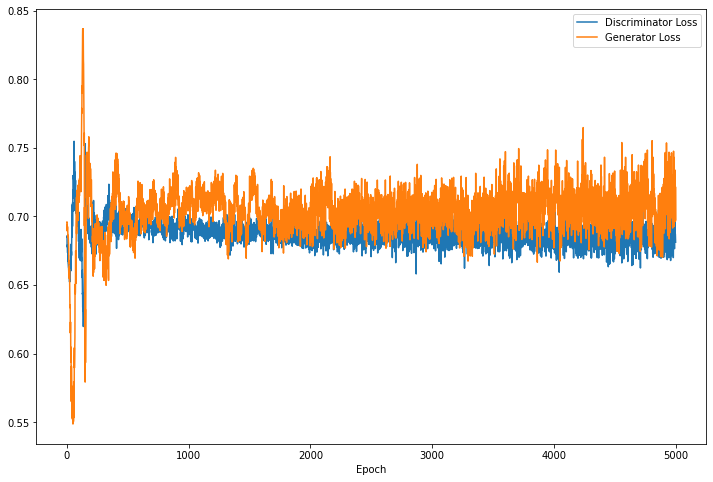

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(history['D_loss'], label='Discriminator Loss')
ax.plot(history['G_loss'], label='Generator Loss')
ax.set_xlabel('Epoch')
plt.legend()
plt.show()

In [5]:
import matplotlib.pyplot as plt
import numpy as np


# Setup parameters visualization parameters
seed = 17
test_size = 100 # number of fraud cases

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer.get_data_batch(train=data.norm_df, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real)

In [6]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

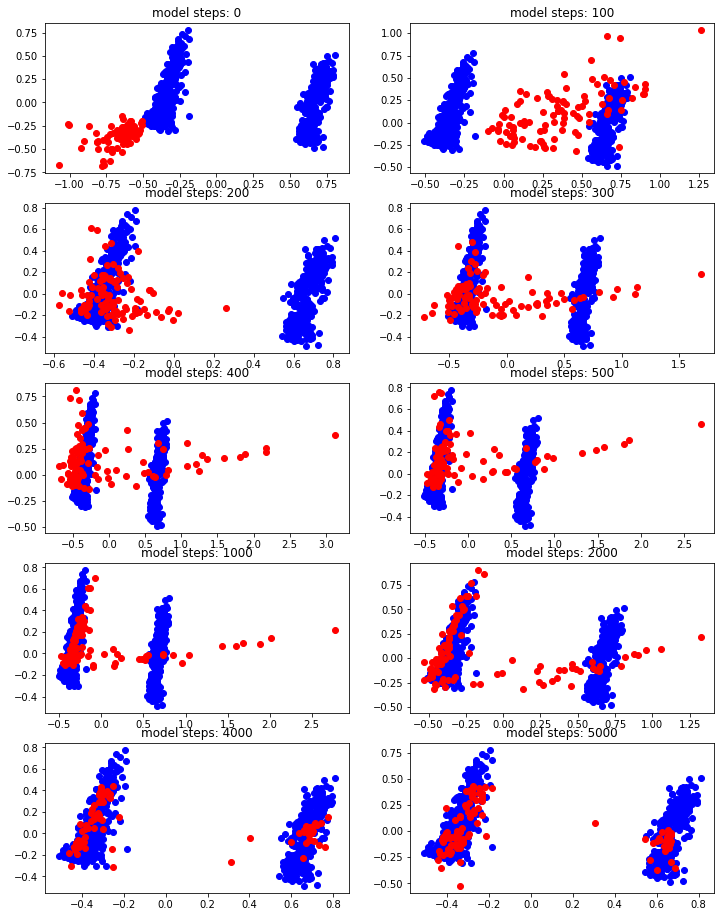

In [7]:
model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']

col1, col2 = 'CITY', 'ETHNICITY'

base_dir = 'model/'

#Actual fraud data visualization
model_steps = [ 0, 100, 200, 300, 400, 500, 1000, 2000, 4000, 5000]


fig, ax = plt.subplots(5, 2, figsize=(12, 16))


for model_step_ix, model_step in enumerate(model_steps):      
    [model_name, with_class, generator_model] = models['GAN']
    generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')
    g_z = generator_model.predict(z)
    g_z_emb = data.pca.transform(g_z)
    ax[model_step_ix // 2, model_step_ix % 2].scatter(X_embedded[:,0], X_embedded[:,1], c='b')
    ax[model_step_ix // 2, model_step_ix % 2].scatter(g_z_emb[:, 0], g_z_emb[:, 1], c='r')
    ax[model_step_ix // 2, model_step_ix % 2].set_title(f'model steps: {model_step}')

In [8]:
data

In [9]:
fooled_samples = data.scaler.inverse_transform(g_z[:,:-1])
generated_df = pd.DataFrame(fooled_samples)
generated_df['8'] = g_z[:,-1]
generated_df.columns = data.df_backup.columns
generated_df['discriminator'] = synthesizer.discriminator.predict(g_z)
generated_df['discriminator'] = generated_df['discriminator'].apply(lambda v: 1 if v > 0.5 else 0)
generated_df = generated_df.round()
generated_df[generated_df < 0] = 0
generated_df

,preg,plas,pres,skin,insu,mass,pedi,age,class,discriminator
0,-0.0,94.0,48.0,19.0,31.0,24.0,1.0,23.0,0.0,1
1,9.0,122.0,79.0,34.0,151.0,36.0,1.0,50.0,0.0,1
2,11.0,152.0,63.0,32.0,181.0,41.0,1.0,35.0,-0.0,1
3,6.0,166.0,64.0,35.0,193.0,30.0,1.0,31.0,1.0,1
4,6.0,165.0,64.0,34.0,190.0,30.0,1.0,31.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...
95,0.0,105.0,59.0,17.0,0.0,28.0,1.0,21.0,-0.0,1
96,5.0,146.0,66.0,24.0,106.0,32.0,1.0,27.0,1.0,0
97,4.0,110.0,52.0,20.0,73.0,27.0,1.0,28.0,0.0,1
98,3.0,119.0,72.0,29.0,0.0,24.0,0.0,41.0,-0.0,0


In [10]:
g_z[:,:-1].shape

(100, 8)

In [11]:
class_col = generated_df['class']
tmp = generated_df.drop(columns=['class' ,'discriminator'], axis=1)
tmp = pd.DataFrame(g_z[:,:-1], columns=data.df.columns[:-1])
tmp = pd.concat([tmp, class_col],axis=1)
tmp

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,-0.002353,0.471995,0.390654,0.192026,0.037037,0.361693,0.209170,0.039838,0.0
1,0.554623,0.615017,0.645490,0.340423,0.178872,0.536634,0.325612,0.485640,0.0
2,0.642739,0.764100,0.515444,0.322459,0.214332,0.605244,0.436307,0.239424,-0.0
3,0.330673,0.835084,0.522981,0.349657,0.227629,0.443584,0.284956,0.174299,1.0
4,0.326492,0.830896,0.523937,0.347276,0.224891,0.443192,0.283181,0.174086,1.0
...,...,...,...,...,...,...,...,...,...
95,-0.076491,0.529507,0.482813,0.169788,-0.011043,0.412374,0.326175,0.002390,-0.0
96,0.312391,0.732314,0.539993,0.243841,0.125744,0.478512,0.249004,0.103558,1.0
97,0.264242,0.551416,0.427296,0.199059,0.086372,0.397786,0.268896,0.124664,0.0
98,0.203882,0.596939,0.592890,0.293654,-0.012926,0.350881,0.167215,0.338251,-0.0


In [12]:
original_emb = data.pca.transform(data.norm_df)
generated_positive_emb = data.pca.transform(tmp[tmp['class'].eq(1)])
generated_negative_emb = data.pca.transform(tmp[tmp['class'].eq(0)])
original_positive_emb = original_emb[data.norm_df[data.norm_df['class'].eq(1)].index.values]
original_negative_emb = original_emb[data.norm_df[data.norm_df['class'].eq(0)].index.values]
failed = data.pca.transform(tmp.iloc[generated_df[generated_df['discriminator'].eq(0)].index])

C:\Users\amits\Anaconda3\envs\home\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\amits\Anaconda3\envs\home\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\amits\Anaconda3\envs\home\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\amits\Anaconda3\envs\home\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [13]:
generated_df['discriminator'].value_counts()

1    74
0    26
Name: discriminator, dtype: int64

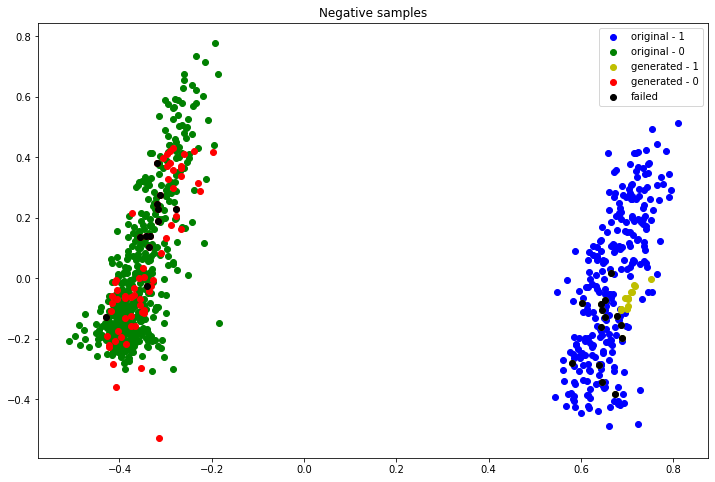

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Negative samples')
ax.scatter(original_positive_emb[:,0], original_positive_emb[:,1],label='original - 1', c='b')
ax.scatter(original_negative_emb[:,0], original_negative_emb[:,1],label='original - 0', c='g')

ax.scatter(generated_positive_emb[:,0], generated_positive_emb[:,1],label='generated - 1', c='y')
ax.scatter(generated_negative_emb[:,0], generated_negative_emb[:,1],label='generated - 0', c='r')
ax.scatter(failed[:,0], failed[:,1],label='failed', c='black')
plt.legend()
plt.show()

In [15]:
generated_df['discriminator'].value_counts()

1    74
0    26
Name: discriminator, dtype: int64

In [16]:
tmp_generated = generated_df[generated_df['discriminator'].eq(1)]
tmp_generated = tmp_generated[tmp_generated['class'].eq(0)]
tmp_generated = tmp_generated.drop(columns=['discriminator', 'class'], axis=1)
tmp_generated

,preg,plas,pres,skin,insu,mass,pedi,age
0,-0.0,94.0,48.0,19.0,31.0,24.0,1.0,23.0
1,9.0,122.0,79.0,34.0,151.0,36.0,1.0,50.0
2,11.0,152.0,63.0,32.0,181.0,41.0,1.0,35.0
5,6.0,110.0,80.0,9.0,0.0,22.0,1.0,53.0
6,3.0,125.0,57.0,13.0,63.0,26.0,0.0,27.0
...,...,...,...,...,...,...,...,...
92,4.0,107.0,94.0,0.0,0.0,24.0,0.0,34.0
93,6.0,107.0,76.0,7.0,0.0,21.0,1.0,52.0
94,9.0,135.0,57.0,24.0,138.0,34.0,1.0,33.0
95,0.0,105.0,59.0,17.0,0.0,28.0,1.0,21.0


In [17]:
tmp_original = data.df_backup
tmp_original = tmp_original[tmp_original['class'].eq(b'tested_negative')]
tmp_original = tmp_original.drop(columns=['class'], axis=1)
tmp_original

,preg,plas,pres,skin,insu,mass,pedi,age
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0
5,5.0,116.0,74.0,0.0,0.0,25.6,0.201,30.0
7,10.0,115.0,0.0,0.0,0.0,35.3,0.134,29.0
10,4.0,110.0,92.0,0.0,0.0,37.6,0.191,30.0
...,...,...,...,...,...,...,...,...
762,9.0,89.0,62.0,0.0,0.0,22.5,0.142,33.0
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0
764,2.0,122.0,70.0,27.0,0.0,36.8,0.340,27.0
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0


In [18]:
from sklearn.metrics.pairwise import euclidean_distances

In [19]:
euclidean_distances(X=tmp_original, Y=tmp_original).mean()

114.76525755980178

In [20]:
generated_distances = euclidean_distances(X=tmp_generated, Y=tmp_original)
print(f'distances shape: {generated_distances.shape}')
generated_distances.mean()

distances shape: (61, 500)


104.9739798002214

In [21]:
columns = data.df.columns[:-1]

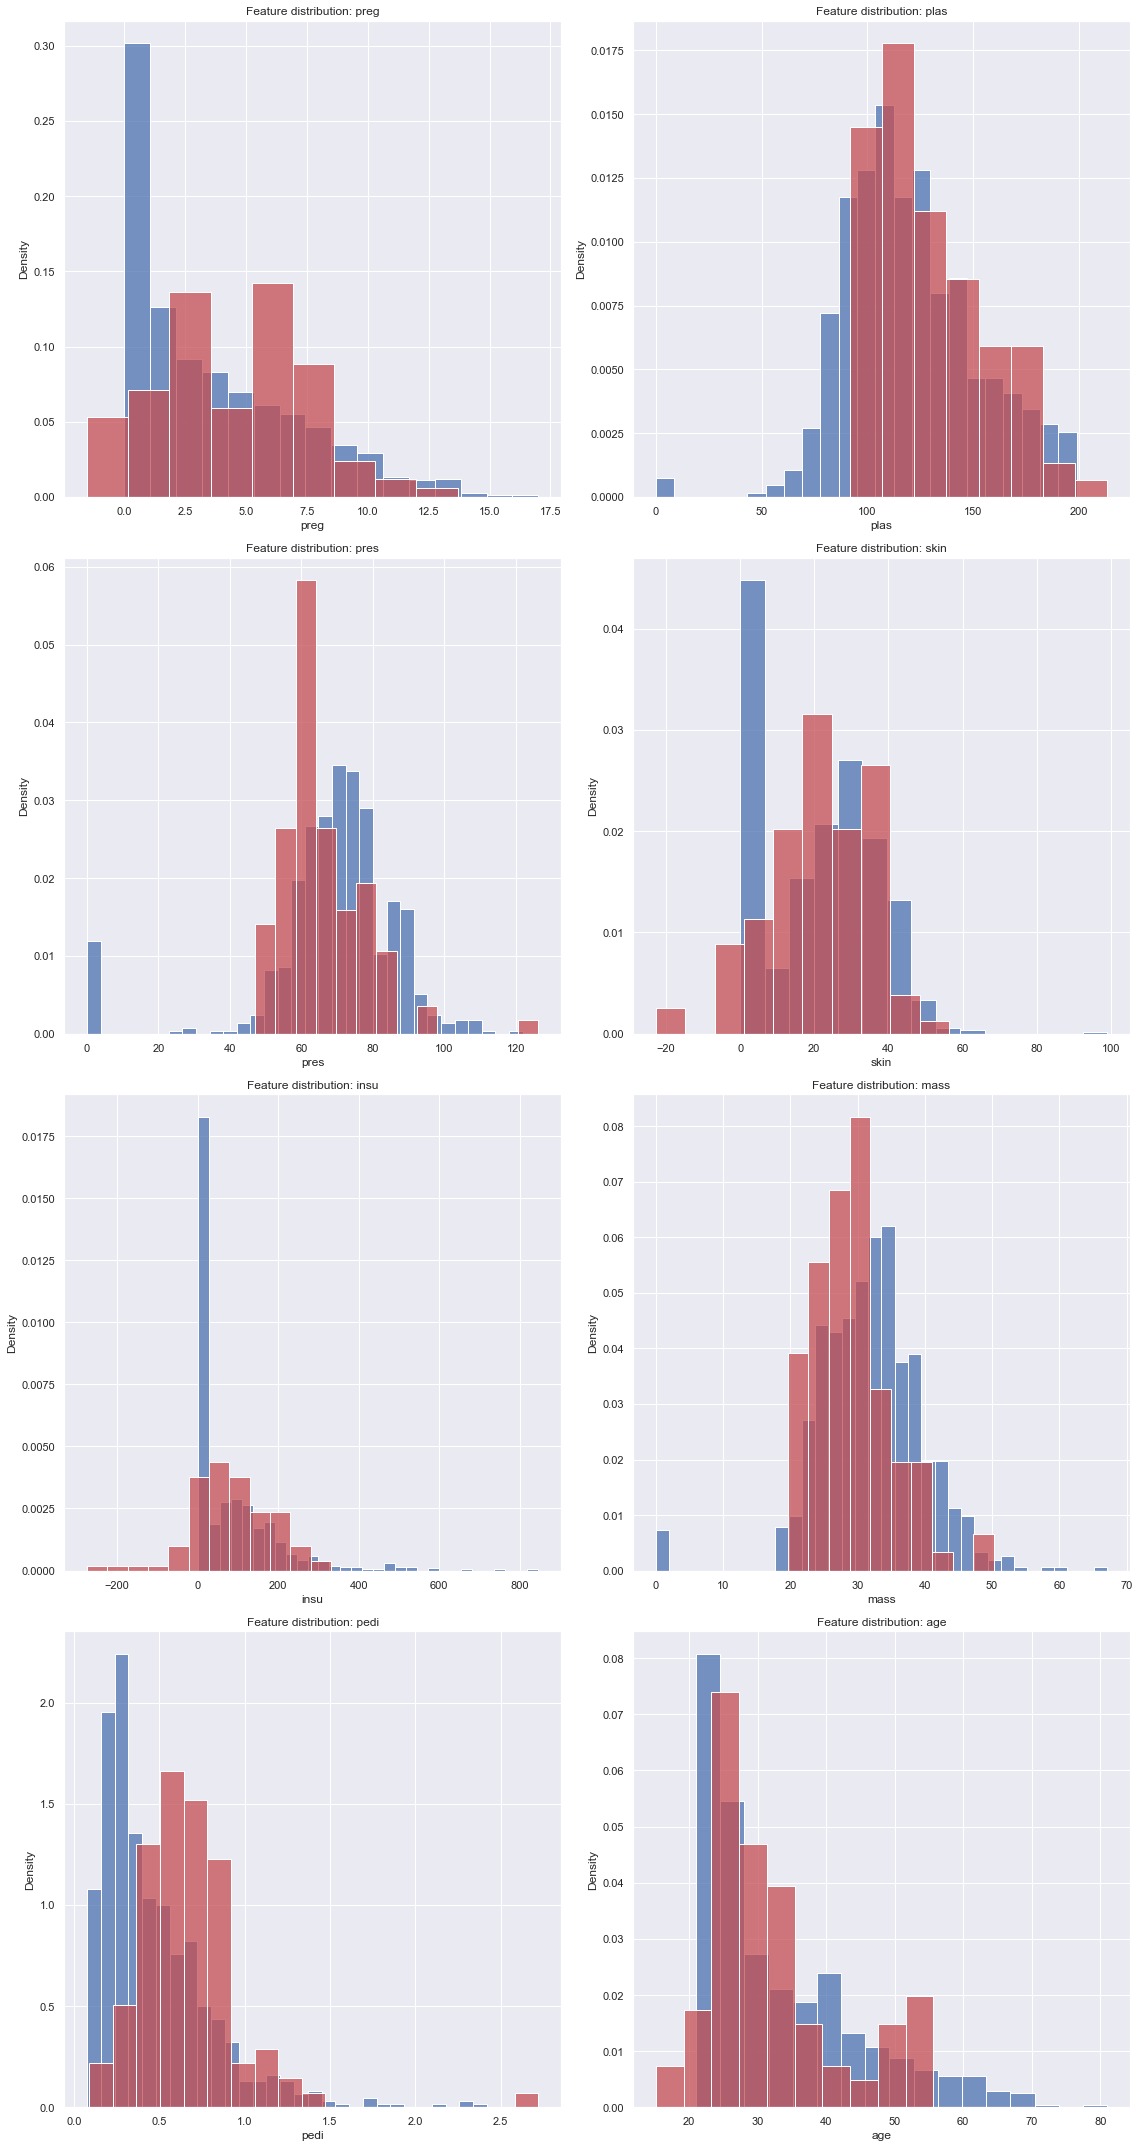

In [24]:
import seaborn as sns, numpy as np

sns.set_theme(); np.random.seed(0)

def plot_feature_dist(df, gen):
    fig, ax = plt.subplots(int(np.ceil(df.shape[1]/2)), 2, figsize=(16, 30))
    for i in range(len(columns)):
        column = columns.values[i]
        ax[i // 2, i % 2].set_title(f'Feature distribution: {column}')
        sns.histplot(df[column], label='Original', stat='density', ax=ax[i // 2, i % 2], color='b')
        sns.histplot(gen[column], label='Generated', stat='density', ax=ax[i // 2, i % 2], color='r')
    fig.tight_layout()
    plt.savefig('diabetes.png')
plot_feature_dist(pd.DataFrame(data.scaler.inverse_transform(data.norm_df.values[:, :-1]), columns=columns), pd.DataFrame(data.scaler.inverse_transform(g_z[:, :-1]), columns=columns))